## Zadanie 5d 
### Zastosowanie optymalizatora do dopasowania modelu/rozkładu do danych rzeczywistych

   Zadanie rozpocznijmy od zaimporotwania bibliotek oraz danych rzek.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

URL = 'https://en.wikipedia.org/wiki/List_of_rivers_of_Belarus'
resp = requests.get(URL)
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
    df = pd.read_html(str(tab))[0]
df

,Name,"Total, km","In Belarus, km"
0,Dnieper River,2145,690
1,Western Dvina,1020,328
2,Neman River,937,459
3,Bug River,831,169
4,Pripyat River,761,495
5,Sozh River,648,493
6,Berezina River,613,613
7,Vilija,510,276
8,Ptsich,421,421
9,Shchara,325,325


   Zadanie polega na znalezieniu optymalnych parametrów a oraz b we wzorze Y = aX + b, gdzie Y jest długością w kraju, natomiast X długością całkowitą tak jak w zadaniu 3d. Żeby rozpocząć proces optymalizacji musimy utworzyć zbiory X oraz Y.

In [2]:
X = df['Total, km'].values
Y = df['In Belarus, km'].values

print('Długości całkowite rzek: %s' % X)
print('Długości rzek w kraju:   %s' % Y)

Długości całkowite rzek: [2145 1020  937  831  761  648  613  510  421  325  297]
Długości rzek w kraju:   [690 328 459 169 495 493 613 276 421 325 297]


W tym laboratorium mamy przeprowadzić trzy eksperyment wybierając losowo punkt startowy poszukiwania optimum. Zaimportujmy jeszcze potrzebne do tego celu biblioteki z implementacją metody Neldera-Meada.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

Potrzebujemy jeszcze kilku założeń żeby rozpocząć eksperymenty. Argumenty a, b mają być wyliczane jako minimum funkcji błędu średniokwadratowego. Przyjmijmy identyczną jak w zadaniu 3d definicję błędu: 
        

$$e_i=y_i-\overline{y_i}.$$

\begin{equation}
Q(a,b) = \frac{1}{N}\sum_{i=1}^Ne_i^2 \
\end{equation}

Ponadto zdefiniujmy stałe oraz funkcje do rysowania:

In [23]:
# ilość danych
DATASIZE = X.size

# funkcja licząca błąd
def count_error(arguments):
    a, b = arguments
    error = 0
    for i in range(0, DATASIZE):
        error = error + ( ( Y[i] - ( a * X[i] + b ) ) ) ** 2
    
    return error / DATASIZE

# rysowanie w 2D
def pokaz_2D(Fcelu, x_historia, zakres):
  x_pocz, x_opt = x_historia[0], x_historia[-1]
  os_x1 = np.linspace(zakres[0], zakres[1], num=100)
  os_x2 = np.linspace(zakres[2], zakres[3], num=100)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
  macierz_Z = Fcelu([siatka_X1, siatka_X2])

  fig, ax = plt.subplots(figsize=(8,8))
  cplot = ax.contourf(siatka_X1, siatka_X2, macierz_Z, 10, cmap='Spectral_r', alpha=1)
  clines = ax.contour(siatka_X1, siatka_X2, macierz_Z, 10, colors='black')
  for punkt in x_historia:
      ax.plot(punkt[0], punkt[1], 'o', 
              color='white', markeredgecolor='black', markersize=5, alpha=0.7)
  ax.plot(x_pocz[0], x_pocz[1], 'd', 
          color='gray', markeredgecolor='black', markersize=10, alpha=0.7)    
  ax.plot(x_opt[0], x_opt[1], 'h', 
          color='white', markeredgecolor='black', markersize=15)
  ax.set_aspect('equal')
  ax.set_xlabel(r'$x_1$', fontsize=16)
  ax.set_ylabel(r'$x_2$', fontsize=16)
  ax.clabel(clines)
  fig.colorbar(cplot)
  return fig, ax

# rysowanie w 3D
def pokaz_3D(Fcelu, zakres):
  os_x1 = np.linspace(zakres[0], zakres[1], 50)
  os_x2 = np.linspace(zakres[2], zakres[3], 50)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)

  fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection':'3d'})
  ax.plot_surface(siatka_X1, siatka_X2, Fcelu([siatka_X1, siatka_X2]), cmap='Spectral_r')
  ax.set_xlabel('$x_1$', fontsize=14)
  ax.set_ylabel('$x_2$', fontsize=14)
  ax.set_zlabel('$F$', fontsize=14)
  plt.show()

# funkcja pomocnicza
def model (parametry, x):
    a, b = parametry
    return a * x + b

Napiszmy pojedynczą metodę, która będzie przeprowadzać eksperyment, korzystającą z powyższego kodu. Pomoże to uniknąć pisania tego samego kilka razy. 

In [27]:
def run_experiment(start, jump):
    # ustalamy punkt startowy
    x_zero = np.random.normal(loc=start, scale=jump, size=2)        
    print('Punkt startowy : ' + str(round(x_zero[0], 4)) + ' ' + str(round(x_zero[1], 4)))  

    # szukamy minimum funkcji błędu i zapamiętujemy punkty żeby przedstawić je na wykresie
    x_opt, x_history = optimize.fmin(
        count_error, 
        x_zero, 
        disp=False,
        retall=True
    )

    print('a = %s' % round(x_opt[0], 4))
    print('b = %s' % round(x_opt[1], 4))
    print('Wartość błędu dla tak wyliczonych wartości a oraz b wynosi %s' % round(count_error(x_opt), 2))
    
    # rysujemy wykresy 2D oraz 3D
    zakres = [-100, 100, -100, 1]
    pokaz_2D(count_error, x_history, zakres)
    plt.show()
    pokaz_3D(count_error, zakres)
    
    # rysujemy linię na tle punktów
    X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
    Y_pred = model(parametry = [x_opt[0], x_opt[1]], x = X_test)
    plt.scatter(X,Y)
    plt.plot(X_test, Y_pred, color = 'tab:orange')
    plt.xlabel('x - Długość całkowita', fontsize = 14)
    plt.ylabel('y - Długość w kraju', fontsize = 14)
    plt.title('Model liniowy - szukanie minimalnego błędu', size = 20)
    plt.show()

## Eksperyment 1

Punkt startowy : 5.6991 3.0136
a = 0.1659
b = 286.7475
Wartość błędu dla tak wyliczonych wartości a oraz b wynosi 15104.65


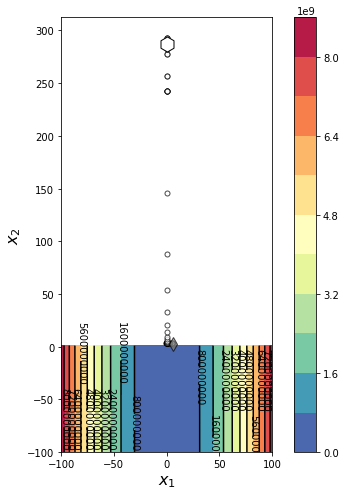

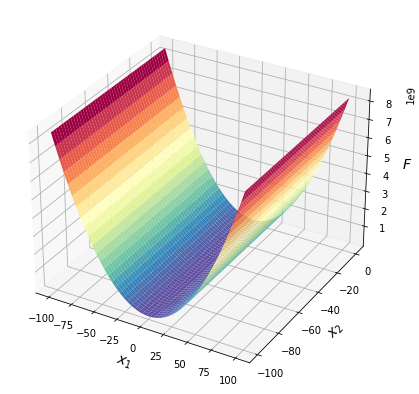

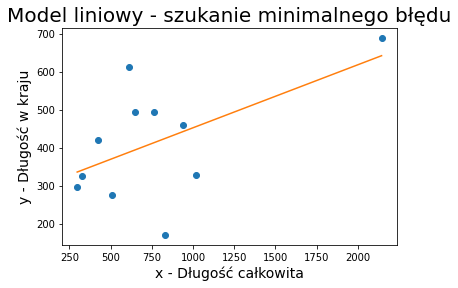

In [28]:
run_experiment(5, 1)

## Eksperyment 2

Punkt startowy : 35.0769 41.9905
a = 0.1659
b = 286.7474
Wartość błędu dla tak wyliczonych wartości a oraz b wynosi 15104.65


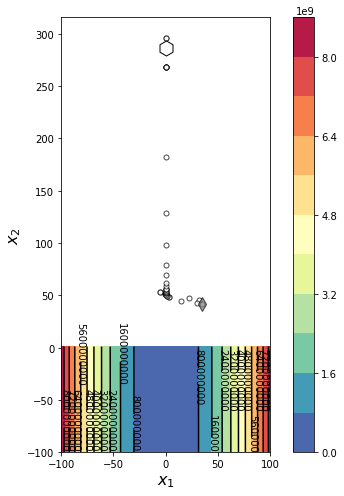

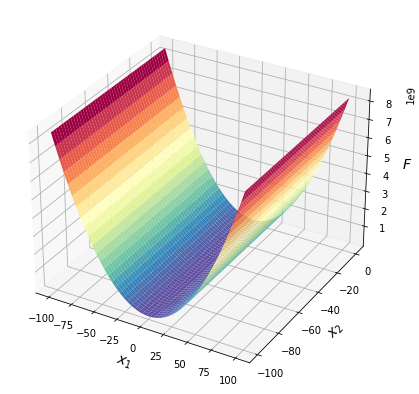

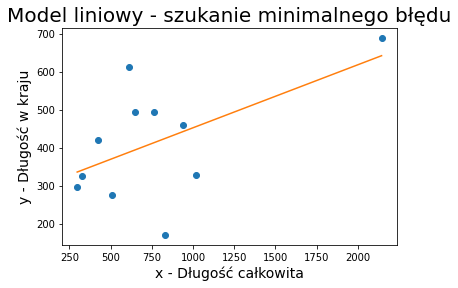

In [7]:
run_experiment(40, 10)

## Eksperyment 3

Punkt startowy : -11.1281 -5.9317
a = 0.1659
b = 286.7474
Wartość błędu dla tak wyliczonych wartości a oraz b wynosi 15104.65


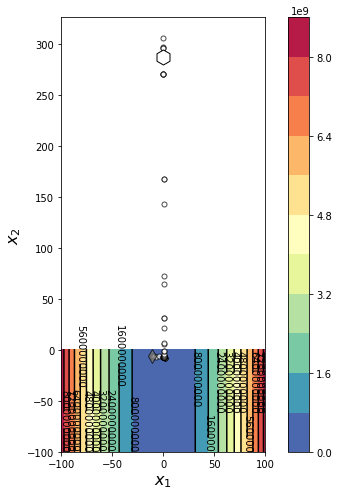

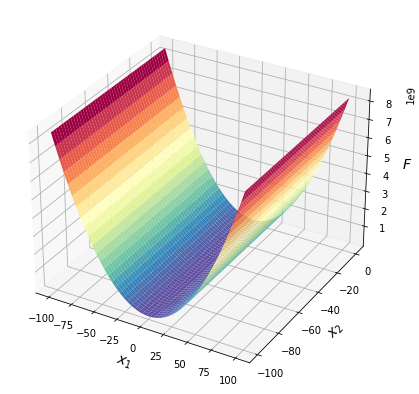

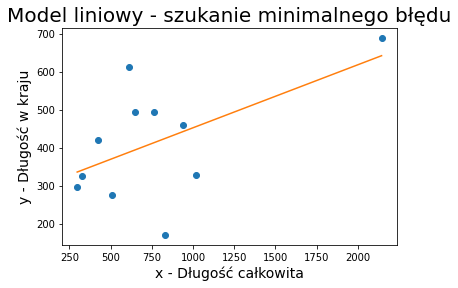

In [8]:
run_experiment(-10, 4)

## Wnioski

   Każdy z trzech eksperymentów daje bardzo podobny wynik, parametr a wyszedł w każdym eksperymencie taki sam, natomiast parametr b różni się dopiero na 4 miejscu po przecinku. Oznacza to że dla danych rzek funkcja błędu ma jedno optimum globalne, do którego dąży metoda Neldera-Meada. Nie ma w tym wypadku większego znaczenia w jakim punkcie zaczniemy, ponieważ danych jest na tyle mało, że po kilku iteracjach metoda znajdzie się w pobliżu szukanego minimum. Ponadto wykres 3D przedstawia tę funkcję jako paraboloidę, co tylko potwierdza powyższe wnioski.  